In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.18.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# !pip show tensorflow
# !pip uninstall -y tensorflow
# !pip install tensorflow --upgrade


In [3]:
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
from sklearn.model_selection import train_test_split


In [4]:
# Mount Google Drive to access the uploaded folder
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Define the main directory path where images are stored
import os

main_folder_path = "/content/drive/My Drive/UTKface_inthewild"

# Check if the main directory exists
if not os.path.exists(main_folder_path):
    print("Error: The folder UTKface_inthewild does not exist in My Drive. Please check the path.")
else:
    print("UTKface_inthewild folder found!")

UTKface_inthewild folder found!


In [6]:
# List all subfolders (part1, part2, part3)
subfolders = [os.path.join(main_folder_path, folder) for folder in os.listdir(main_folder_path) if os.path.isdir(os.path.join(main_folder_path, folder))]

print(f"Found {len(subfolders)} subfolders: {subfolders}")


Found 3 subfolders: ['/content/drive/My Drive/UTKface_inthewild/part2', '/content/drive/My Drive/UTKface_inthewild/part1', '/content/drive/My Drive/UTKface_inthewild/part3']


In [7]:

import glob

# Retrieves all image paths
image_files = glob.glob(os.path.join(main_folder_path, "**", "*.jpg"), recursive=True)

print(f"Total images found: {len(image_files)}")



Total images found: 24129


In [8]:
import re

# Define the valid UTKFace filename pattern
def is_utkface_image(filename):
    # UTKFace pattern: age_gender_race_date.jpg
    return bool(re.match(r"^\d+_\d+_\d+_\d+\.(jpg|jpeg|png)$", filename))

# Apply the function
# Filter images based on the UTKFace naming pattern
utkface_images = [img for img in image_files if is_utkface_image(os.path.basename(img))]
print(f"Valid UTKFace images found: {len(utkface_images)}")


Valid UTKFace images found: 24101


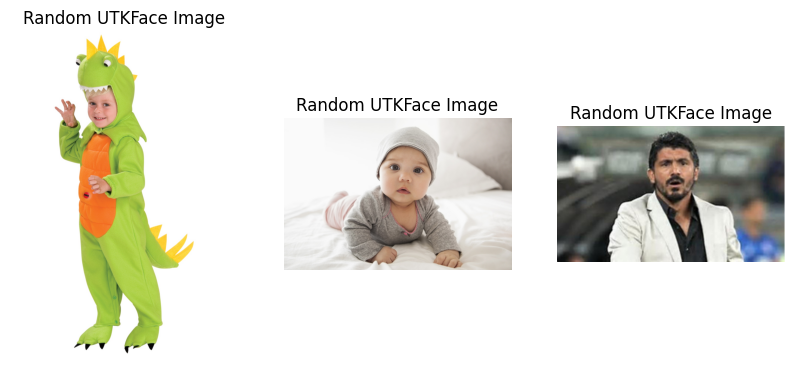

In [9]:
# import random

# # Display the random valid UTKFace image
# if len(utkface_images) > 1:
#     random_image_path = random.choice(utkface_images)
#     print(f"Displaying a random UTKFace image: {random_image_path}")

#     image = Image.open(random_image_path)
#     plt.imshow(image)
#     plt.axis("off") # Hide axis labels
#     plt.show()


import random
import matplotlib.pyplot as plt
from PIL import Image

# Number of random images to display
num_images = 3  # Change this value to display more or fewer images

# Check if there are enough images available
if len(utkface_images) > 0:
    random_images = random.sample(utkface_images, min(num_images, len(utkface_images)))

    # Display the selected images
    fig, axes = plt.subplots(1, len(random_images), figsize=(10, 5))

    if len(random_images) == 1:
        axes = [axes]  # Ensure axes is iterable when only one image is selected

    for ax, image_path in zip(axes, random_images):
        image = Image.open(image_path)
        ax.imshow(image)
        ax.axis("off")  # Hide axis labels
        ax.set_title("Random UTKFace Image")

    plt.show()
else:
    print("No UTKFace images found.")


## PRE-PROCESSING





In [10]:
# from tensorflow.keras.layers import Rescaling
# import os

# # Set parameters
# IMG_SIZE = (64, 64)   # Resize all images
# BATCH_SIZE = 16       # Number of images in one batch
# SEED = 42

# # Define the dataset path
# dataset_dir = "/content/drive/MyDrive/UTKface_inthewild"

# # Create a dataset directly from directory (loads images on-the-fly)
# full_dataset = tf.keras.utils.image_dataset_from_directory(
#     dataset_dir,
#     label_mode=None,              # No labels (age will be extracted separately if needed)
#     image_size=IMG_SIZE,          # Resize images
#     batch_size=BATCH_SIZE,
#     shuffle=True,
#     seed=SEED                     # Ensure reproducibility
# )

# # Normalize pixel values to 0-1
# normalization_layer = Rescaling(1./255)
# full_dataset = full_dataset.map(lambda x: normalization_layer(x))

# # Shuffle and split the dataset (80% train, 20% val)
# dataset_size = full_dataset.cardinality().numpy()
# val_size = int(0.2 * dataset_size)

# val_dataset = full_dataset.take(val_size)
# train_dataset = full_dataset.skip(val_size)

# print(f"Preprocessing completed.")
# print(f"Training batches: {train_dataset.cardinality().numpy()}, Validation batches: {val_dataset.cardinality().numpy()}")


In [11]:
import tensorflow as tf
import os
import numpy as np
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split


# -----------------------------
# CONFIG
# -----------------------------
IMG_SIZE = (64, 64)   # Resize all images
BATCH_SIZE = 32       # Number of images in one batch
SEED = 42

# Path to UTKFace dataset folder
dataset_path = "/content/drive/MyDrive/UTKface_inthewild"

# -----------------------------
# LOAD IMAGE PATHS & AGE LABELS
# -----------------------------
image_paths = []
age_labels = []

for root, dirs, files in os.walk(dataset_path):
    for fname in files:
        if fname.endswith('.jpg'):
            try:
                age = int(fname.split("_")[0])  # Extract age from filename
                full_path = os.path.join(root, fname)
                image_paths.append(full_path)
                age_labels.append(age)
            except:
                continue  # Skip corrupted or improperly named files

print(f"Total images with valid labels: {len(image_paths)}")

# -----------------------------
# TRAIN-VALIDATION SPLIT
# -----------------------------
train_paths, val_paths, train_ages, val_ages = train_test_split(
    image_paths, age_labels, test_size=0.2, random_state=SEED)

# -----------------------------
# CREATE DATASET PIPELINE
# -----------------------------
def load_and_preprocess(path, label):
    image_str = tf.io.read_file(path)
    img = tf.image.decode_jpeg(image_str, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_ages))
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_ages))

train_ds = train_ds.map(load_and_preprocess).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(load_and_preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


Total images with valid labels: 24129


In [12]:
# -----------------------------
# BUILD MODEL
# -----------------------------

# Build the model with ResNet50 base
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
base_model.trainable = False  # Freeze base model

# Add custom regression head
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')  # Regression output
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss=MeanAbsoluteError(),
    metrics=['mae']
)

# -----------------------------
# TRAIN MODEL
# -----------------------------

# Add callbacks
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model_resnet_age.h5", save_best_only=True)

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop, checkpoint]
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/20
604/604 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 19.1943 - mae: 19.1943

604/604 ━━━━━━━━━━━━━━━━━━━━ 1681s 2s/step - loss: 19.1900 - mae: 19.1900 - val_loss: 15.2499 - val_mae: 15.2499
Epoch 2/20
599/604 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 15.2963 - mae: 15.2963

604/604 ━━━━━━━━━━━━━━━━━━━━ 44s 70ms/step - loss: 15.2974 - mae: 15.2974 - val_loss: 15.1353 - val_mae: 15.1353
Epoch 3/20
599/604 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 15.1863 - mae: 15.1863

604/604 ━━━━━━━━━━━━━━━━━━━━ 44s 69ms/step - loss: 15.1870 - mae: 15.1870 - val_loss: 15.1060 - val_mae: 15.1060
Epoch 4/20
598/604 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 15.1730 - mae: 15.1730

604/604 ━━━━━━━━━━━━━━━━━━━━ 44s 70ms/step - loss: 15.1737 - mae: 15.1737 - val_loss: 15.0353 - val_mae: 15.0353
Epoch 5/20
599/604 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 15.0355 - mae: 15.0355

604/604 ━━━━━━━━━━━━━━━━━━━━ 44s 69ms/step - loss: 15.0366 - mae: 15.0366 - val_loss: 15.0134 - val_mae: 15.0134
Epoch 6/20
600/604 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 15.1439 - mae: 15.1439

604/604 ━━━━━━━━━━━━━━━━━━━━ 44s 70ms/step - loss: 15.1444 - mae: 15.1444 - val_loss: 14.9856 - val_mae: 14.9856
Epoch 7/20
601/604 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 15.0559 - mae: 15.0559

604/604 ━━━━━━━━━━━━━━━━━━━━ 44s 69ms/step - loss: 15.0564 - mae: 15.0564 - val_loss: 14.9710 - val_mae: 14.9710
Epoch 8/20
604/604 ━━━━━━━━━━━━━━━━━━━━ 43s 68ms/step - loss: 15.0211 - mae: 15.0211 - val_loss: 15.0262 - val_mae: 15.0262
Epoch 9/20
601/604 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 15.0202 - mae: 15.0202

604/604 ━━━━━━━━━━━━━━━━━━━━ 44s 70ms/step - loss: 15.0208 - mae: 15.0208 - val_loss: 14.9445 - val_mae: 14.9445
Epoch 10/20
599/604 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 14.9834 - mae: 14.9834

604/604 ━━━━━━━━━━━━━━━━━━━━ 43s 68ms/step - loss: 14.9842 - mae: 14.9842 - val_loss: 14.9297 - val_mae: 14.9297
Epoch 11/20
604/604 ━━━━━━━━━━━━━━━━━━━━ 43s 68ms/step - loss: 14.9424 - mae: 14.9424 - val_loss: 14.9495 - val_mae: 14.9495
Epoch 12/20
604/604 ━━━━━━━━━━━━━━━━━━━━ 43s 67ms/step - loss: 14.9743 - mae: 14.9743 - val_loss: 14.9636 - val_mae: 14.9636
Epoch 13/20
602/604 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 14.8709 - mae: 14.8709

604/604 ━━━━━━━━━━━━━━━━━━━━ 43s 69ms/step - loss: 14.8718 - mae: 14.8718 - val_loss: 14.9066 - val_mae: 14.9066
Epoch 14/20
604/604 ━━━━━━━━━━━━━━━━━━━━ 42s 67ms/step - loss: 14.9882 - mae: 14.9882 - val_loss: 14.9259 - val_mae: 14.9259
Epoch 15/20
604/604 ━━━━━━━━━━━━━━━━━━━━ 42s 67ms/step - loss: 14.9243 - mae: 14.9243 - val_loss: 14.9552 - val_mae: 14.9552
Epoch 16/20
604/604 ━━━━━━━━━━━━━━━━━━━━ 42s 67ms/step - loss: 14.9409 - mae: 14.9409 - val_loss: 14.9483 - val_mae: 14.9483
Epoch 17/20
604/604 ━━━━━━━━━━━━━━━━━━━━ 43s 68ms/step - loss: 14.8786 - mae: 14.8786 - val_loss: 15.1087 - val_mae: 15.1087
Epoch 18/20
604/604 ━━━━━━━━━━━━━━━━━━━━ 42s 67ms/step - loss: 14.9895 - mae: 14.9895 - val_loss: 14.9743 - val_mae: 14.9743


### Evaluation & Training History Plot

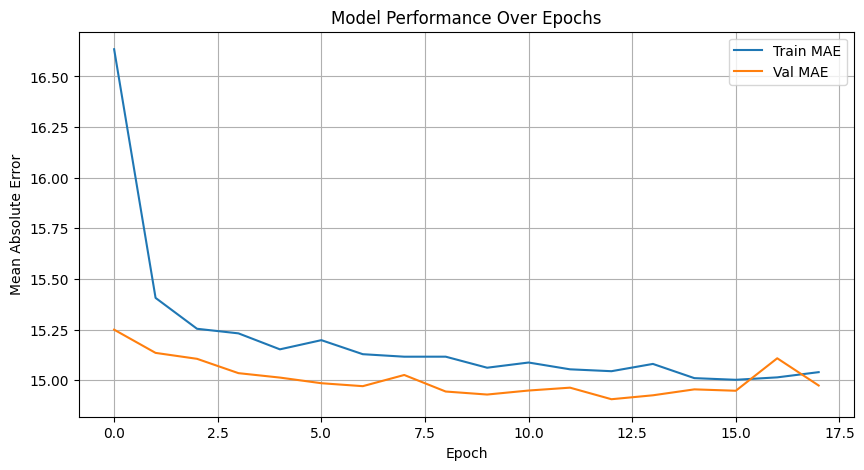

151/151 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 14.6133 - mae: 14.6133

 Final Validation MAE: 14.91 years


In [13]:
# Plot training and validation MAE over epochs
def plot_training_history(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Val MAE')
    plt.title("Model Performance Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Mean Absolute Error")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training_history(history)

# Evaluate model on validation dataset
val_loss, val_mae = model.evaluate(val_ds)
print(f"\n Final Validation MAE: {val_mae:.2f} years")


### Prediction & Visualization

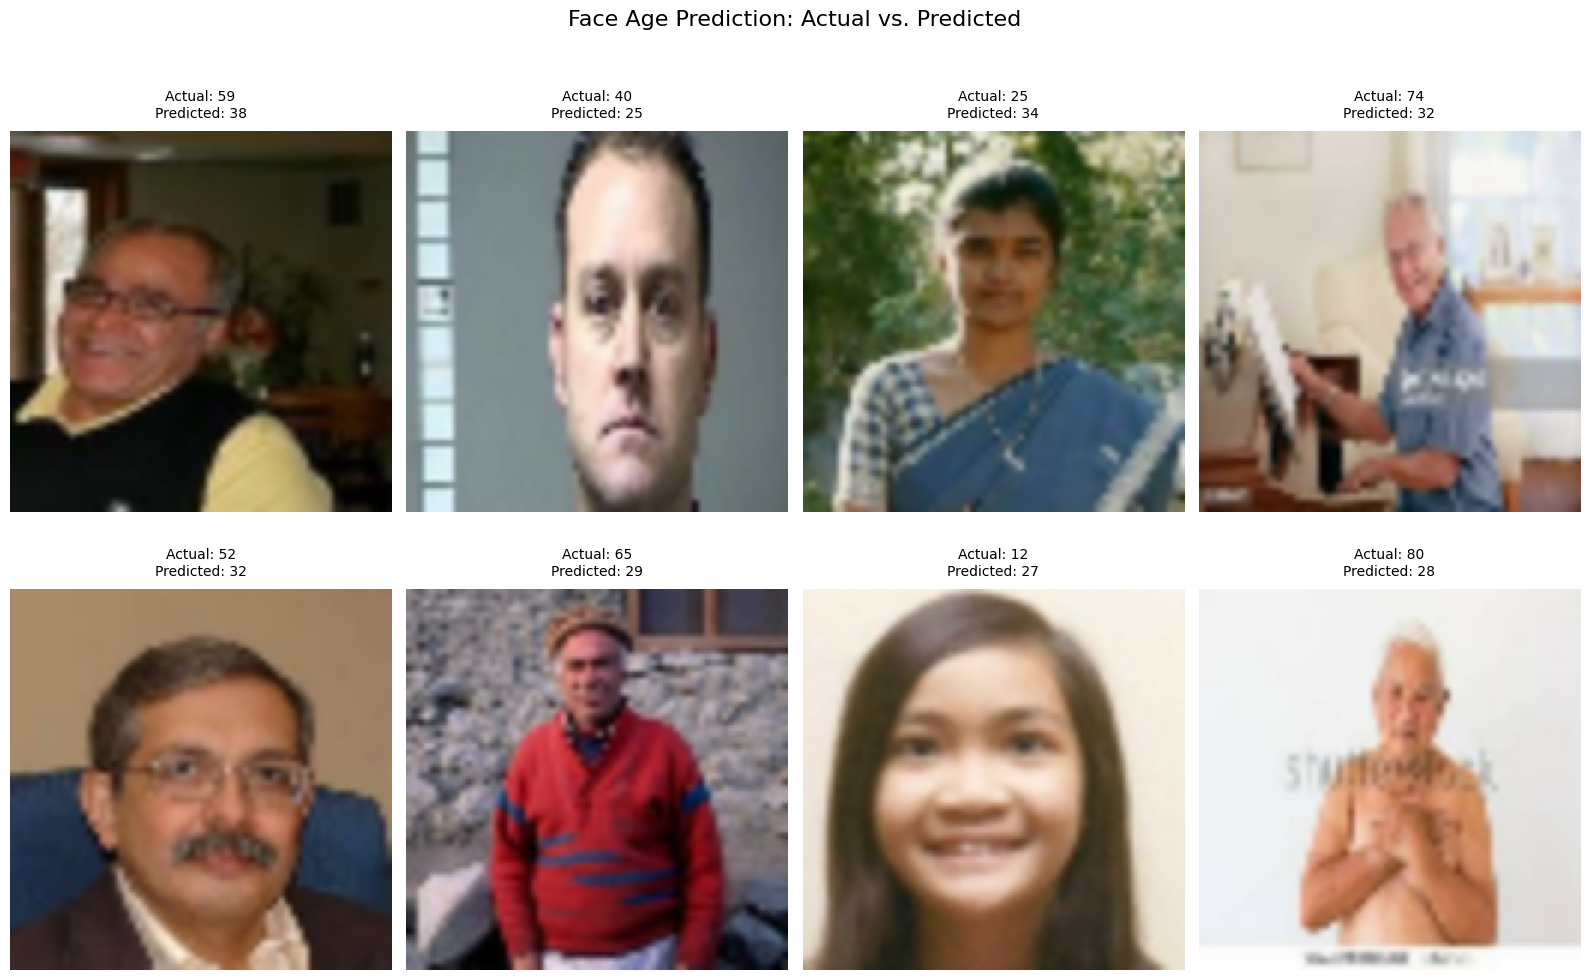

In [14]:
# Step 1: Convert validation set to list (for indexing)
val_images = list(val_ds.unbatch().as_numpy_iterator())

# Step 2: Pick N random samples to visualize
import random
num_samples = 8
samples = random.sample(val_images, num_samples)


# Plot predictions with improved layout
plt.figure(figsize=(16, 10))


for i, (img, actual_age) in enumerate(samples):
    # Predict age
    img_input = tf.expand_dims(img, axis=0)
    predicted_age = model.predict(img_input, verbose=0)[0][0]

    # Upscale image for display only (128x128) and convert to uint8
    upscaled_img = tf.image.resize(img, (128, 128)).numpy()
    upscaled_img = (upscaled_img * 255).astype("uint8")

    # Plot
    plt.subplot(2, 4, i+1)
    plt.imshow(upscaled_img)
    plt.axis('off')
    plt.title(f"Actual: {int(actual_age)}\nPredicted: {int(predicted_age)}", fontsize=10, pad=10)

plt.suptitle("Face Age Prediction: Actual vs. Predicted", fontsize=16, y=1.02)
plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.tight_layout()
plt.show()


In [15]:
# Save this plot to file
# plt.savefig("age_predictions_grid.png", dpi=300, bbox_inches='tight')


### Fine-Tune the ResNet50 Model

In [16]:
#  Unfreeze Layers from ResNet50

# Unfreeze the base model
base_model.trainable = True

# Optional: Freeze some early layers to avoid overfitting
for layer in base_model.layers[:100]:
    layer.trainable = False

print(f"Total trainable layers after unfreezing: {sum([layer.trainable for layer in base_model.layers])}")


Total trainable layers after unfreezing: 75


In [17]:
# Compile with Lower Learning Rate

from tensorflow.keras.optimizers import Adam

# Recompile with a lower learning rate for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Smaller LR to avoid destroying pre-trained weights
    loss='mae',
    metrics=['mae']
)


In [18]:
# Train the Model Again

# Fine-tune the model
fine_tune_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,  # Fewer epochs to start with
    callbacks=[early_stop, checkpoint]
)

Epoch 1/10
604/604 ━━━━━━━━━━━━━━━━━━━━ 90s 95ms/step - loss: 22.5859 - mae: 22.5859 - val_loss: 18.1605 - val_mae: 18.1605
Epoch 2/10
604/604 ━━━━━━━━━━━━━━━━━━━━ 43s 68ms/step - loss: 18.7630 - mae: 18.7630 - val_loss: 16.9030 - val_mae: 16.9030
Epoch 3/10
604/604 ━━━━━━━━━━━━━━━━━━━━ 43s 69ms/step - loss: 16.7350 - mae: 16.7350 - val_loss: 15.6452 - val_mae: 15.6452
Epoch 4/10
603/604 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 15.7003 - mae: 15.7003

604/604 ━━━━━━━━━━━━━━━━━━━━ 44s 71ms/step - loss: 15.6996 - mae: 15.6996 - val_loss: 14.6788 - val_mae: 14.6788
Epoch 5/10
603/604 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 14.7607 - mae: 14.7607

604/604 ━━━━━━━━━━━━━━━━━━━━ 44s 70ms/step - loss: 14.7606 - mae: 14.7606 - val_loss: 14.5404 - val_mae: 14.5404
Epoch 6/10
603/604 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 14.3567 - mae: 14.3567

604/604 ━━━━━━━━━━━━━━━━━━━━ 45s 71ms/step - loss: 14.3568 - mae: 14.3568 - val_loss: 14.3465 - val_mae: 14.3465
Epoch 7/10
603/604 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 13.9912 - mae: 13.9912

604/604 ━━━━━━━━━━━━━━━━━━━━ 45s 70ms/step - loss: 13.9910 - mae: 13.9910 - val_loss: 14.2208 - val_mae: 14.2208
Epoch 8/10
604/604 ━━━━━━━━━━━━━━━━━━━━ 43s 68ms/step - loss: 13.7133 - mae: 13.7133 - val_loss: 14.5309 - val_mae: 14.5309
Epoch 9/10
604/604 ━━━━━━━━━━━━━━━━━━━━ 43s 68ms/step - loss: 13.3902 - mae: 13.3902 - val_loss: 14.4222 - val_mae: 14.4222
Epoch 10/10
603/604 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 13.1963 - mae: 13.1963

604/604 ━━━━━━━━━━━━━━━━━━━━ 44s 71ms/step - loss: 13.1965 - mae: 13.1965 - val_loss: 13.6518 - val_mae: 13.6518


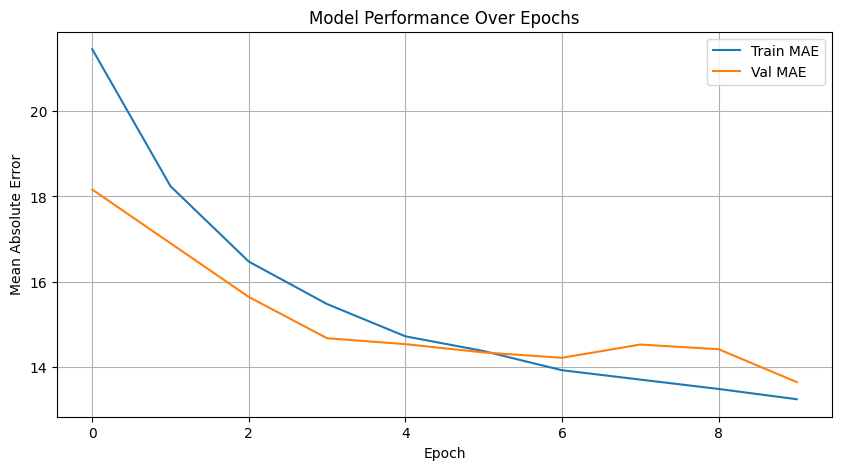

In [19]:
# Plot fine-tuning training history
plot_training_history(fine_tune_history)


In [20]:
# Save Your Model for Deployment
model.save("/content/fine_tuned_age_model.h5")


### Predict Again and Visualize Results

<ipython-input-21-8d8baacc8187>:24: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


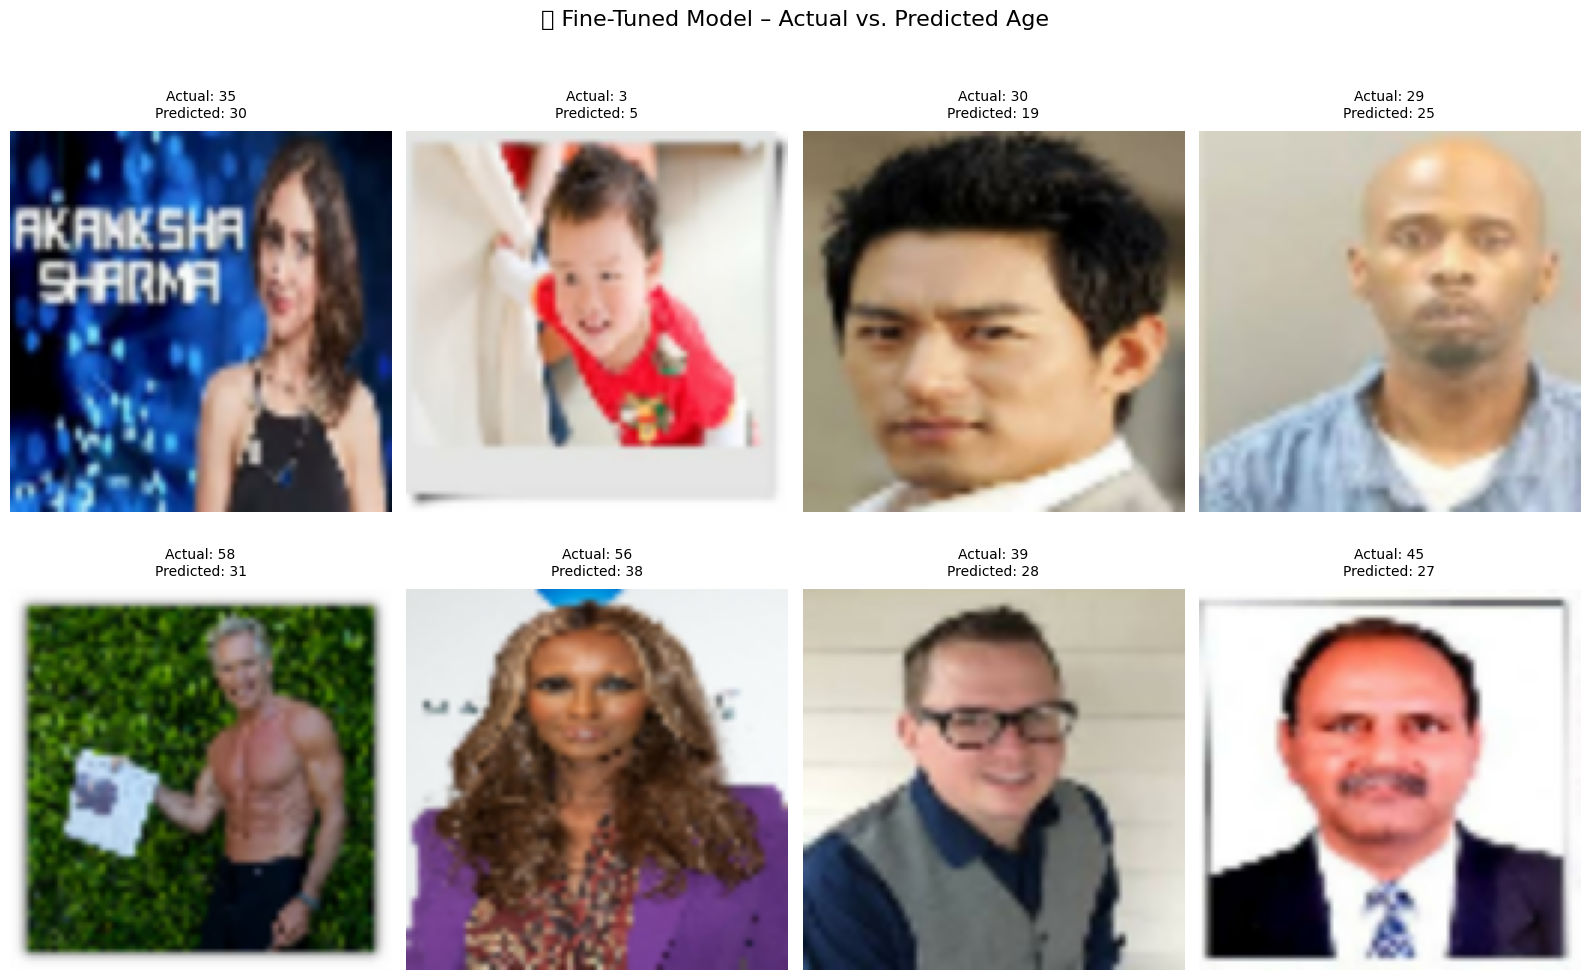

In [21]:
# Pick 8 fresh samples from validation set
val_images = list(val_ds.unbatch().as_numpy_iterator())
samples = random.sample(val_images, 8)

# Plot predictions
plt.figure(figsize=(16, 10))
for i, (img, actual_age) in enumerate(samples):
    # Predict
    img_input = tf.expand_dims(img, axis=0)
    predicted_age = model.predict(img_input, verbose=0)[0][0]

    # Upscale for display
    upscaled_img = tf.image.resize(img, (128, 128)).numpy()
    upscaled_img = (upscaled_img * 255).astype("uint8")

    # Display
    plt.subplot(2, 4, i+1)
    plt.imshow(upscaled_img)
    plt.axis('off')
    plt.title(f"Actual: {int(actual_age)}\nPredicted: {int(predicted_age)}", fontsize=10, pad=10)

plt.suptitle("🧠 Fine-Tuned Model – Actual vs. Predicted Age", fontsize=16, y=1.02)
plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.tight_layout()
plt.show()


### Saving the Model for Submission or Reuse

In [22]:
# Save fine-tuned model as HDF5 format
model.save("/content/fine_tuned_age_model.h5")


### Generate Pseudo-Labels Using Trained Model

In [23]:
pseudo_images = val_images[:500]  # Example: take 500 "unlabeled" images

pseudo_X = []
pseudo_y = []

for img, _ in pseudo_images:
    pred = model.predict(tf.expand_dims(img, axis=0), verbose=0)[0][0]
    pseudo_X.append(img)
    pseudo_y.append(pred)  # Use model's prediction as label

print(f"Generated {len(pseudo_y)} pseudo-labels.")


Generated 500 pseudo-labels.


### Combine with True Labeled Data

In [24]:
# Convert train_ds to numpy arrays for combining
real_X = []
real_y = []
for img, label in train_ds.unbatch().take(500):  # You can use full or partial
    real_X.append(img)
    real_y.append(label)

# Combine both
combined_X = tf.convert_to_tensor(real_X + pseudo_X)
combined_y = tf.convert_to_tensor(real_y + pseudo_y)

# Shuffle & create new dataset
combined_ds = tf.data.Dataset.from_tensor_slices((combined_X, combined_y))
combined_ds = combined_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


### Retrain the Model with Combined Dataset

In [25]:
# Optionally recompile with a lower LR
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='mae',
    metrics=['mae']
)

# Train again
pseudo_history = model.fit(
    combined_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=[early_stop]
)


Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 51s 750ms/step - loss: 8.8006 - mae: 8.8006 - val_loss: 14.1660 - val_mae: 14.1660
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 218ms/step - loss: 8.2422 - mae: 8.2422 - val_loss: 14.0344 - val_mae: 14.0344
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 220ms/step - loss: 8.2009 - mae: 8.2009 - val_loss: 14.7115 - val_mae: 14.7115
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 218ms/step - loss: 7.3168 - mae: 7.3168 - val_loss: 14.4156 - val_mae: 14.4156
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 224ms/step - loss: 7.7092 - mae: 7.7092 - val_loss: 13.8300 - val_mae: 13.8300


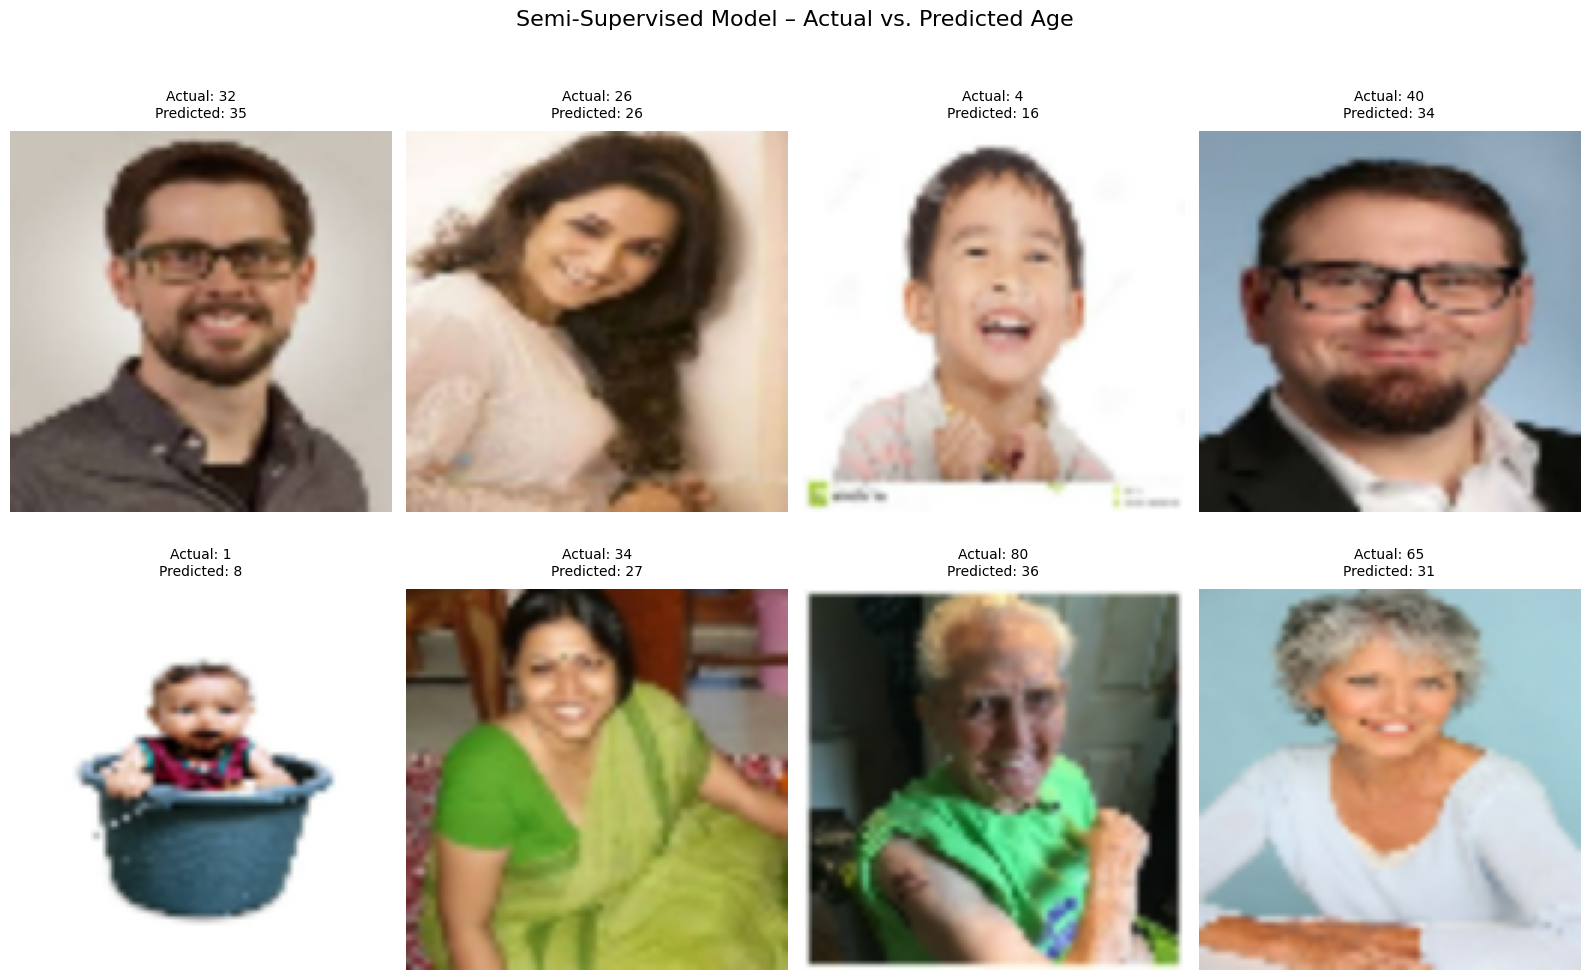

In [26]:

# Use some validation data for predictions
val_images = list(val_ds.unbatch().as_numpy_iterator())
samples = random.sample(val_images, 8)

plt.figure(figsize=(16, 10))
for i, (img, actual_age) in enumerate(samples):
    # Predict
    img_input = tf.expand_dims(img, axis=0)
    predicted_age = model.predict(img_input, verbose=0)[0][0]

    # Upscale for display
    upscaled_img = tf.image.resize(img, (128, 128)).numpy()
    upscaled_img = (upscaled_img * 255).astype("uint8")

    # Plot
    plt.subplot(2, 4, i + 1)
    plt.imshow(upscaled_img)
    plt.axis('off')
    plt.title(f"Actual: {int(actual_age)}\nPredicted: {int(predicted_age)}", fontsize=10, pad=10)

plt.suptitle("Semi-Supervised Model – Actual vs. Predicted Age", fontsize=16, y=1.02)
plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.tight_layout()
plt.show()


### Exporting Full Comparison Table to PDF

In [28]:

from matplotlib.backends.backend_pdf import PdfPages

# Performance comparison data
data = [
    ["Model Phase", "Description", "Validation MAE (Years)"],
    ["Baseline", "Frozen ResNet50 + Regression Head", "14.87"],
    ["Fine-Tuned", "Top 50 layers unfrozen, low LR", "13.71"],
    ["Semi-Supervised", "+500 pseudo-labeled samples", "14.15"]
]

# Create a PDF file with the table
with PdfPages("/content/performance_comparison_table.pdf") as pdf:
    fig, ax = plt.subplots(figsize=(10, 2))
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=data, colLabels=None, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 2.0)
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()

print("Performance comparison table saved as PDF: performance_comparison_table.pdf")


Performance comparison table saved as PDF: performance_comparison_table.pdf
